# Ensemble optimization

This notebook is an example on how to perform an ensemble optimization. It closly follows the procedure described in  
>['Goerz et al. *Physical Review A 90*, 032329 (2014)'](https://doi.org/10.1103/PhysRevA.90.032329)

ToDo: Add futher text

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
%watermark -v --iversions

qutip       4.4.0.dev0+48770fff
numpy       1.15.4
scipy       1.1.0
matplotlib  3.0.2
matplotlib.pylab  1.15.4
CPython 3.6.7
IPython 7.2.0


In [2]:
import krotov
import itertools

$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid #2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

## Model

### One qubit Hamiltonian

The qubits are realized in two hyperfine levels of a cesium atom. In addition to that, we also have an intermediate and a Rydberg level. The levels are depicted below:
<center><img src="https://journals.aps.org/pra/article/10.1103/PhysRevA.90.032329/figures/1/medium" width="300"/></center>

This is Fig. 1 from the publication.



We label use qutip to get the individual states and the unity matrix for one qubit:

In [3]:
rydberg = qutip.basis(4,3)    # Rydberg level |r>
intermd = qutip.basis(4,2)    # intermediate level |i>
qb_excited = qutip.basis(4,1) # qubit excited state |1>
qb_ground  = qutip.basis(4,0) # qubit ground state |0>

unity_1q = qutip.qeye(4)

Now we set set up the parameters according to the paper and construct the Hamiltonian according to the paper:

\begin{align*}
\hat{\mathcal{H}}_{\mathrm{1q}} &=  \begin{pmatrix}
0 & 0 & \Omega_{\mathrm{B}}(t) & 0 \\
0 & E_1 & 0 & 0 \\
\Omega_{\mathrm{B}}(t) & 0 & \Delta_1 & \Omega_{\mathrm{R}}(t) \\
0 & 0 & \Omega_{\mathrm{R}}(t) & \Delta_2 
\end{pmatrix} \\
&= \Omega_{\mathrm{B}}(t)\bigg( \ket{0}\bra{i} + \ket{i}\bra{0} \bigg) \ 
        + \ \Omega_{\mathrm{R}}(t)\bigg( \ket{r}\bra{i} + \ket{i}\bra{r} \bigg) \ 
        + \ \text{diag}(0,E_1,\Delta_1,\Delta_2) 
\end{align*}

To account for the decay of the intermediate level, we add a coefficient $-\frac{i\gamma}{2}$, with $\gamma=\frac{1}{\tau}>0$ to the intermediate level, leading to a non hermitian hamiltonian (also c.f. [the notebook on the lambda system with non hermitian hamiltonian](03_example_lambda_system_rwa_non_hermitian.ipynb)) :

\begin{align*}
\hat{\mathcal{H}}_{\mathrm{1q}} &=  \begin{pmatrix}
0 & 0 & \Omega_{\mathrm{B}}(t) & 0 \\
0 & E_1 & 0 & 0 \\
\Omega_{\mathrm{B}}(t) & 0 & \Delta_1-\frac{i\gamma}{2} & \Omega_{\mathrm{R}}(t) \\
0 & 0 & \Omega_{\mathrm{R}}(t) & \Delta_2 
\end{pmatrix} 
\end{align*}

In [4]:
# Omega blue
rabi_freq_blue = .1715 # in GHz

# Omega red
rabi_freq_red = .1484 # in GHz

# Diagonal
e1      = 9.100 # in GHz
delta_1 = 1.273 # in GHz
delta_2 = 0     # in GHz

# decay time (in ns)
tau = 150.0 

def get_1q_hams(rabi_freq_blue=rabi_freq_blue, rabi_freq_red=rabi_freq_red, 
                diag=[0,e1,delta_1,delta_2], gamma=1./tau                   
                ):
    
    blue_driving_hamiltonian = rabi_freq_blue * (qb_ground*intermd.dag() +  intermd*qb_ground.dag())
    red_driving_hamiltonian = rabi_freq_red * (rydberg*intermd.dag() +  intermd*rydberg.dag())
     
    # adding diagonal + dissipation   
    eigen_ham = qutip.qdiags(diag,0) + qutip.qdiags([0,0,-100*.5j*gamma,0],0)
        
    return eigen_ham, blue_driving_hamiltonian, red_driving_hamiltonian

<div class="alert alert-block alert-success">MG: The usual convention for Python function names is get_1q_hams, instead of camel case. Also "global" isn't strictly necessary unless you write to those variables inside the function (but if you prefer to keep it for now, in order to track which non-local variables the function refers to, I don't mind).
</div>

### Two qubit Hamiltonian

We define the controls for the left atom and compose the left and right atom single qubit hamiltonian:
\begin{align}
    \op{\mathcal{H}}_{\text{1q}}^{\ \text{left }} &= \op{\mathcal{H}}_{\text{1q}} \otimes \mathbb{1} & 
    \op{\mathcal{H}}_{\text{1q}}^{\ \text{right}} &= \mathbb{1} \otimes \op{\mathcal{H}}_{\text{1q}}
\end{align}

and combine them to the two qubit hamiltonian

\begin{equation}
    \op{\mathcal{H}}_{\text{2q}} = \op{\mathcal{H}}_{\text{1q}}^{\ \text{right}} 
                                       + \op{\mathcal{H}}_{\text{1q}}^{\ \text{left}}
                                       - u \ket{rr}\bra{rr} 
\end{equation}


In [48]:
rydberg_coupling = .05726 # in GHz

def get_ham_2q(u=rydberg_coupling, **kwargs):
    """  """
    
    rr_ket = qutip.tensor(rydberg,rydberg)
    rr_rr_ineraction = u * rr_ket*rr_ket.dag()
    
    #Get one qubit Hamiltonian
    eigen_ham, blue_driving_hamiltonian, red_driving_hamiltonian = get_1q_hams(**kwargs)
    
    #Left atom hamiltonian
    ### get the non controlled part of the left atom hamiltonian
    ham_1q_l_0 = qutip.tensor(eigen_ham,unity_1q)
    ### ... and the controlled parts
    ham_1q_l_1_blue = [ qutip.tensor( blue_driving_hamiltonian, unity_1q ), lambda x: 1 ]
    ham_1q_l_1_red  = [ qutip.tensor( red_driving_hamiltonian , unity_1q ), lambda x: 1 ]
                 
    #Get one qubit Hamiltonian
    eigen_ham, blue_driving_hamiltonian, red_driving_hamiltonian = get_1q_hams(**kwargs)
    
    #right atom hamiltonian
    ### get the non controlled part of the left atom hamiltonian
    ham_1q_r_0 = qutip.tensor(unity_1q,eigen_ham)
    ### ... and the controlled parts
    ham_1q_r_1_blue = [ qutip.tensor( unity_1q, blue_driving_hamiltonian ) , lambda x: 1 ]
    ham_1q_r_1_red  = [ qutip.tensor( unity_1q,  red_driving_hamiltonian ) , lambda x: 1 ]
    
    
    # get H_0 Hamiltonian (no controls) ...
    ham_2q_0 = ham_1q_r_0 + ham_1q_r_0 - rr_rr_ineraction
    # ... and add the controls
    ham_2q = [ham_2q_0,  ham_1q_l_1_blue, ham_1q_l_1_red,  ham_1q_r_1_blue, ham_1q_r_1_red]
    
    
    return ham_2q


<div class="alert alert-block alert-success">MG: This might be a bit too much. I'd just have get_1q_hams, and then a single additional routine that returns the complete (H, c_ops). In particular, getHam1qL and getHam1qR aren't really necessary.
</div>

<div class="alert alert-block alert-info">MK: I think that should be better. .
</div>

In [50]:
Ham = get_ham_2q()

### Cphase gate

The classical cphase gate is given as follows

In [55]:
O = qutip.qip.cphase(np.pi)
O

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]

## Optimization without ensembles

For the pulse optimization, we define define two guess pulses for each of the atoms:

In [56]:
t_start, t_stop, length = 0, 800, 400 # in ns
tlist = np.linspace(t_start, t_stop, length)

left_atom_pi_duration = 425 # in ns

def right_atom_pulse(t_start,t_stop):
    func = lambda t,args: krotov.shapes.blackman(t,t_start,t_stop) +1e-16 #account for rounding
    return func

def left_atom_pulse(t_start,t_stop, pi_duration=left_atom_pi_duration):
    func = lambda t,args: krotov.shapes.blackman(t,t_start,t_start+pi_duration)+ \
                          krotov.shapes.blackman(t,t_stop-pi_duration,t_stop)  + 2e-16 #account for rounding
    return func

Which looks like

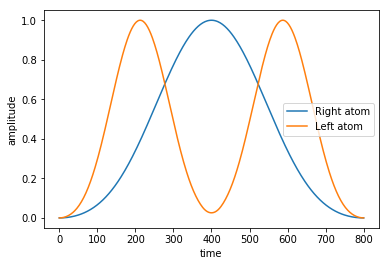

In [57]:
fig, ax = plt.subplots()
ax.plot(tlist, right_atom_pulse(t_start,t_stop)(tlist,None),label='Right atom')
ax.plot(tlist,  left_atom_pulse(t_start,t_stop)(tlist,None),label='Left atom' )
plt.legend()
ax.set_xlabel('time')
ax.set_ylabel('amplitude')
plt.show()

And add the pulses to the Hamiltonian

In [58]:
Ham[1][1] =  left_atom_pulse(t_start,t_stop) #  left atom blue
Ham[2][1] =  left_atom_pulse(t_start,t_stop) #  left atom red
Ham[3][1] = right_atom_pulse(t_start,t_stop) # right atom blue
Ham[4][1] = right_atom_pulse(t_start,t_stop) # right atom red

### Taking into account the gate

In [64]:
basis_states = [qutip.tensor(A,B) for A,B in itertools.product([qb_ground,qb_excited],repeat=2)]
basis_proj   = [bs*bs.dag() for bs in basis_states]

In [65]:
objectives = krotov.gate_objectives(
    basis_states=basis_states, gate=O, H=Ham)

In [66]:
objectives

[Objective[|(4⊗4)⟩ - {[NonHerm[4⊗4,4⊗4], [Herm[4⊗4,4⊗4], u5(t)], [Herm[4⊗4,4⊗4], u6(t)], [Herm[4⊗4,4⊗4], u7(t)], [Herm[4⊗4,4⊗4], u8(t)]]} - |(4⊗4)⟩],
 Objective[|(4⊗4)⟩ - {[NonHerm[4⊗4,4⊗4], [Herm[4⊗4,4⊗4], u5(t)], [Herm[4⊗4,4⊗4], u6(t)], [Herm[4⊗4,4⊗4], u7(t)], [Herm[4⊗4,4⊗4], u8(t)]]} - |(4⊗4)⟩],
 Objective[|(4⊗4)⟩ - {[NonHerm[4⊗4,4⊗4], [Herm[4⊗4,4⊗4], u5(t)], [Herm[4⊗4,4⊗4], u6(t)], [Herm[4⊗4,4⊗4], u7(t)], [Herm[4⊗4,4⊗4], u8(t)]]} - |(4⊗4)⟩],
 Objective[|(4⊗4)⟩ - {[NonHerm[4⊗4,4⊗4], [Herm[4⊗4,4⊗4], u5(t)], [Herm[4⊗4,4⊗4], u6(t)], [Herm[4⊗4,4⊗4], u7(t)], [Herm[4⊗4,4⊗4], u8(t)]]} - |(4⊗4)⟩]]

In [67]:
krotov.objectives.summarize_qobj(Ham)

'[NonHerm[4⊗4,4⊗4], [Herm[4⊗4,4⊗4], u5(t)], [Herm[4⊗4,4⊗4], u6(t)], [Herm[4⊗4,4⊗4], u7(t)], [Herm[4⊗4,4⊗4], u8(t)]]'

In [68]:
len(objectives)

4

In [69]:
lambda_11 = lambda_21 = lambda_31 = lambda_41 = .05


pulse_options = {
    Ham[1][1]: krotov.PulseOptions(lambda_a=lambda_11, shape=lambda t: Ham[1][1](t,None)),
    Ham[2][1]: krotov.PulseOptions(lambda_a=lambda_21, shape=lambda t: Ham[2][1](t,None)),
    Ham[3][1]: krotov.PulseOptions(lambda_a=lambda_31, shape=lambda t: Ham[3][1](t,None)),
    Ham[4][1]: krotov.PulseOptions(lambda_a=lambda_41, shape=lambda t: Ham[4][1](t,None)),
}

def print_fidelity(**args): 
    F_re = np.average(np.array(args['tau_vals']).real)
    print("Iteration %d: \tF = %f" % (args['iteration'], F_re))
    return F_re

### Simulate the dynamics of the guess pulse

In [70]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

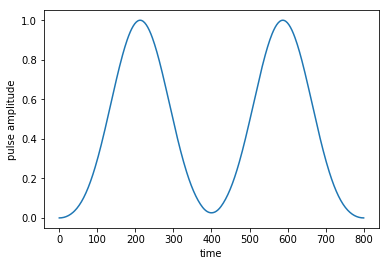

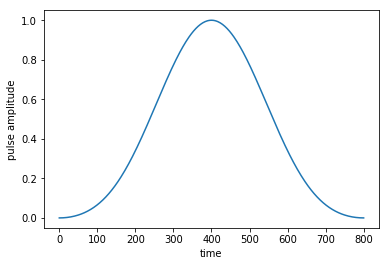

In [77]:
plot_pulse(Ham[1][1], tlist)
plot_pulse(Ham[3][1], tlist)

In [78]:
guess_dynamics = [objctv.mesolve(tlist, e_ops=basis_proj) for objctv in objectives] 

In [95]:
def plot_population(results):
    fig, axs = plt.subplots(2,2)
    for idx,ax in enumerate(axs.flatten()):
        ax.plot(results[idx].times, results[idx].expect[0], label='00')
        ax.plot(results[idx].times, results[idx].expect[1], label='01')
        ax.plot(results[idx].times, results[idx].expect[2], label='10')
        ax.plot(results[idx].times, results[idx].expect[3], label='11')
        ax.legend()
        ax.set_xlabel('time')
        ax.set_ylabel('population')
    plt.show(fig)

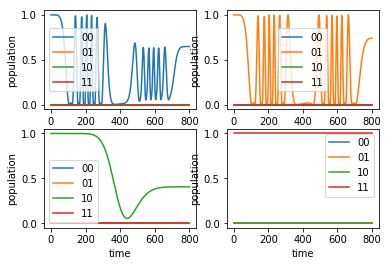

In [96]:
plot_population(guess_dynamics)

### Optimize

In [101]:
%%time
oct_result = krotov.optimize_pulses(
    objectives, pulse_options, tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=print_fidelity, iter_stop=16)

KeyboardInterrupt: 

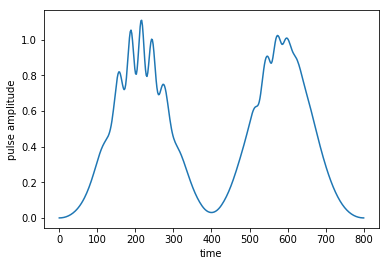

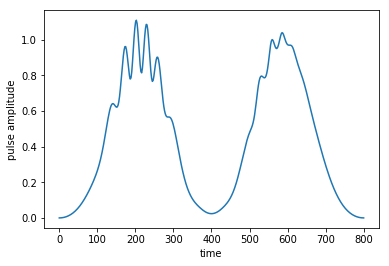

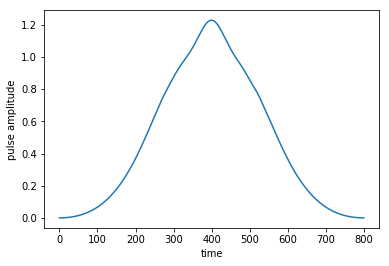

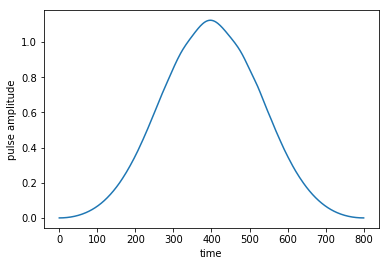

In [97]:
plot_pulse(oct_result.optimized_controls[0], tlist)
plot_pulse(oct_result.optimized_controls[1], tlist)
plot_pulse(oct_result.optimized_controls[2], tlist)
plot_pulse(oct_result.optimized_controls[3], tlist)

In [99]:
opt_dynamics = [opt_objctv.mesolve( tlist, e_ops=basis_proj) for opt_objctv in oct_result.optimized_objectives]

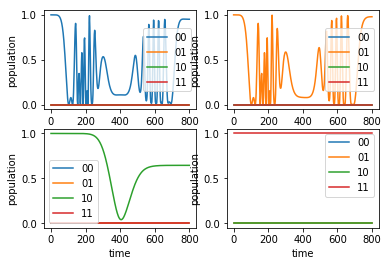

In [100]:
plot_population(opt_dynamics)

## Optimization *with* ensembles

Now, that we are able to optimize our system with the given Hamiltonian, we want to make it more robust with respect to fluctuations in the amplitude and the Rydberg level.
For this we choose an ensamble with N=9 Hamiltonians, each sampling the values of $\Delta_{\mathrm{ryd}}= \pm 300\mathrm{kHz}$ and the the dipole coupling strength $\pm 5\%$ 

###  Getting the ensemble of Hamiltonians

In [63]:
ham_ensamble=[]
pulse_option_ensamble = {}
for Δryd in [-.3e-3,0,.3e-3]:
    for dipl_coupl_str_factor in [.95,1.,1.05]:
        if Δryd == 0 and dipl_coupl_str_factor==1:
            continue
        ensamble_hamiltonian = \
            get_ham_2q(rabi_freq_blue=dipl_coupl_str_factor*rabi_freq_blue,
                       rabi_freq_red =dipl_coupl_str_factor*rabi_freq_red, 
                       diag=[0,e1,delta_1,delta_2+Δryd])
        
        #adding pulse options for the whole ensamble
        ensamble_hamiltonian[1][1] = Ham[1][1] #  left atom blue
        ensamble_hamiltonian[2][1] = Ham[2][1] #  left atom red
        ensamble_hamiltonian[3][1] = Ham[3][1] # right atom blue
        ensamble_hamiltonian[4][1] = Ham[4][1] # right atom red
        
        pulse_option_ensamble.update(
         {  ensamble_hamiltonian[1][1]: krotov.PulseOptions(
                        lambda_a=lambda_11, shape=lambda t: ensamble_hamiltonian[1][1](t,None)),
            ensamble_hamiltonian[2][1]: krotov.PulseOptions(
                        lambda_a=lambda_21, shape=lambda t: ensamble_hamiltonian[2][1](t,None)),
            ensamble_hamiltonian[3][1]: krotov.PulseOptions(
                        lambda_a=lambda_31, shape=lambda t: ensamble_hamiltonian[3][1](t,None)),
            ensamble_hamiltonian[4][1]: krotov.PulseOptions(
                        lambda_a=lambda_41, shape=lambda t: ensamble_hamiltonian[4][1](t,None)),
          })
                
        ham_ensamble.append(ensamble_hamiltonian)
pulse_option_ensamble.update(pulse_options)                

In [64]:
ensemble_objectives = krotov.objectives.ensemble_objectives(objectives, ham_ensamble)

In [65]:
%%time
oct_result = krotov.optimize_pulses(
    ensemble_objectives, pulse_option_ensamble, tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=print_fidelity, iter_stop=4)

KeyboardInterrupt: 

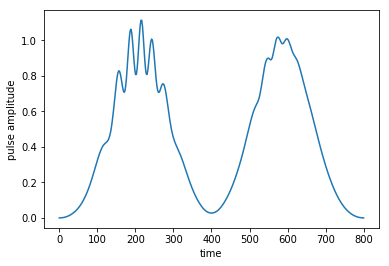

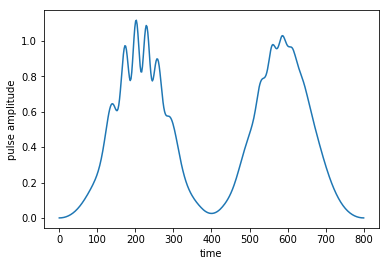

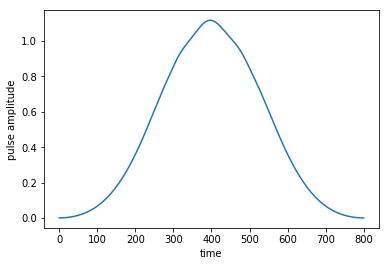

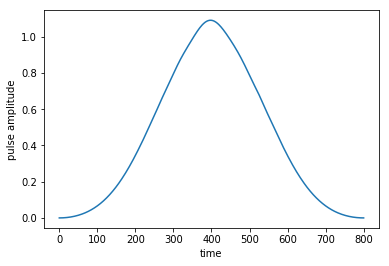

In [61]:
plot_pulse(oct_result.optimized_controls[0], tlist)
plot_pulse(oct_result.optimized_controls[1], tlist)
plot_pulse(oct_result.optimized_controls[2], tlist)
plot_pulse(oct_result.optimized_controls[3], tlist)